In [1]:
import pandas as pd
from pyarrow.parquet import ParquetFile
import dask.dataframe as dd
import os
import xarray as xr
import ujson
import pprint

#%matplotlib inline

In [2]:
# These fs options don't work for http... beware!
so = dict(mode="rb", anon=True, default_fill_cache=False, default_cache_type="first")

In [3]:
def gen_json(u, fs, outf=None):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)
        p = u.split("/")
        date = p[3]
        fname = p[5]
        if outf:
            # outf = f'{json_dir}{date}.{fname}.json'
            with open(outf, "wb") as f:
                f.write(ujson.dumps(h5chunks.translate()).encode())
        else:
            return h5chunks.translate()

In [4]:
# dir_files = [os.path.join("../short_range_18files", files) for files in os.listdir("../short_range_18files")]
# dir_files = [os.path.join("short_range_2files", files) for files in os.listdir("short_range_2files")]
# print(dir_files)
dir_files = [
    "nwm.t00z.short_range.channel_rt.f001.conus.nc",
    "nwm.t00z.short_range.channel_rt.f002.conus.nc",
    "nwm.t00z.short_range.channel_rt.f003.conus.nc",
    "nwm.t00z.short_range.channel_rt.f004.conus.nc",
    "nwm.t00z.short_range.channel_rt.f005.conus.nc",
    "nwm.t00z.short_range.channel_rt.f006.conus.nc",
    "nwm.t00z.short_range.channel_rt.f007.conus.nc",
    "nwm.t00z.short_range.channel_rt.f008.conus.nc",
    "nwm.t00z.short_range.channel_rt.f009.conus.nc",
    "nwm.t00z.short_range.channel_rt.f010.conus.nc",
    "nwm.t00z.short_range.channel_rt.f011.conus.nc",
    "nwm.t00z.short_range.channel_rt.f012.conus.nc",
    "nwm.t00z.short_range.channel_rt.f013.conus.nc",
    "nwm.t00z.short_range.channel_rt.f014.conus.nc",
    "nwm.t00z.short_range.channel_rt.f015.conus.nc",
    "nwm.t00z.short_range.channel_rt.f016.conus.nc",
    "nwm.t00z.short_range.channel_rt.f017.conus.nc",
    "nwm.t00z.short_range.channel_rt.f018.conus.nc",
]

In [5]:
import fsspec
import xarray as xr
from kerchunk.hdf import SingleHdf5ToZarr

fs = fsspec.filesystem("gcs", anon=True)

# https://storage.googleapis.com/national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc
# gcs_url = "gcs://national-water-model/nwm.20220911/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc"
gcs_url = "gcs://national-water-model/nwm.20220911/short_range/"

sr_h5 = []
for f in dir_files:
    print(f)
    sr_h5.append(gen_json(gcs_url + f, fs))

nwm.t00z.short_range.channel_rt.f001.conus.nc
nwm.t00z.short_range.channel_rt.f002.conus.nc
nwm.t00z.short_range.channel_rt.f003.conus.nc
nwm.t00z.short_range.channel_rt.f004.conus.nc
nwm.t00z.short_range.channel_rt.f005.conus.nc
nwm.t00z.short_range.channel_rt.f006.conus.nc
nwm.t00z.short_range.channel_rt.f007.conus.nc
nwm.t00z.short_range.channel_rt.f008.conus.nc
nwm.t00z.short_range.channel_rt.f009.conus.nc
nwm.t00z.short_range.channel_rt.f010.conus.nc
nwm.t00z.short_range.channel_rt.f011.conus.nc
nwm.t00z.short_range.channel_rt.f012.conus.nc
nwm.t00z.short_range.channel_rt.f013.conus.nc
nwm.t00z.short_range.channel_rt.f014.conus.nc
nwm.t00z.short_range.channel_rt.f015.conus.nc
nwm.t00z.short_range.channel_rt.f016.conus.nc
nwm.t00z.short_range.channel_rt.f017.conus.nc
nwm.t00z.short_range.channel_rt.f018.conus.nc


In [6]:
%%time
fds = []
for xj in sr_h5:
    backend_args = {
        "consolidated": False,
        "storage_options": {
            "fo": xj,
            # Adding these options returns a properly dimensioned but otherwise null dataframe
            # "remote_protocol": "https",
            # "remote_options": {'anon':True}
        },
    }
    fds.append(
        xr.open_dataset(
            "reference://",
            engine="zarr",
            mask_and_scale=False,
            backend_kwargs=backend_args,
        )
    )

CPU times: total: 1.03 s
Wall time: 12.9 s


In [7]:
%%time
ds = xr.concat(fds, dim="time")
ds

CPU times: total: 6.5 s
Wall time: 23.3 s


<xarray.Dataset>
Dimensions:         (time: 18, feature_id: 2776738, reference_time: 1)
Coordinates:
  * feature_id      (feature_id) int32 101 179 181 ... 1180001803 1180001804
  * reference_time  (reference_time) datetime64[ns] 2022-09-11
  * time            (time) datetime64[ns] 2022-09-11T01:00:00 ... 2022-09-11T...
Data variables:
    crs             (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    nudge           (time, feature_id) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    qBtmVertRunoff  (time, feature_id) int32 12184 26581 9311 ... 418 584 947
    qBucket         (time, feature_id) int32 341 858 234 87 32 ... 0 4 10 13 17
    qSfcLatRunoff   (time, feature_id) int32 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    streamflow      (time, feature_id) int32 18 1 1 1 1 0 1 0 ... 0 0 0 0 0 0 0
    velocity        (time, feature_id) int32 8 10 10 1 1 7 14 ... 0 3 2 1 2 0 2
Attributes: (12/19)
    Conventions:                CF-1.6
    NWM_version_number:         v2.2
    TITLE:                      OUTPUT FROM NWM v2.2
    cdm_datatype:               Station
    code_version:               v5.2.0-beta2
    dev:                        dev_ prefix indicates development/internal me...
    ...                         ...
    model_output_type:          channel_rt
    model_output_valid_time:    2022-09-11_01:00:00
    model_total_valid_times:    18
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    station_dimension:          feature_id
    stream_order_output:        1

In [8]:
df = ds["streamflow"].to_dataframe()

In [9]:
# df = df.streamflow
df

streamflow
time                feature_id            
2022-09-11 01:00:00 101                 18
                    179                  1
                    181                  1
                    183                  1
                    185                  1
...                                    ...
2022-09-11 18:00:00 1180001800           0
                    1180001801           0
                    1180001802           0
                    1180001803           0
                    1180001804           0

[49981284 rows x 1 columns]

In [10]:
%%time
# df = pd.Series.to_frame(df)

df.to_parquet(
    "../data/parquet_all_feature_ids.gzip", engine="pyarrow", compression="gzip"
)

CPU times: total: 33.5 s
Wall time: 33.6 s


In [11]:
ParquetFile("../data/parquet_all_feature_ids.gzip").metadata  #  num_columns: 3

  created_by: parquet-cpp-arrow version 9.0.0
  num_columns: 3
  num_rows: 49981284
  num_row_groups: 1
  format_version: 2.6
  serialized_size: 2374

CPU times: total: 25 s
Wall time: 25.2 s


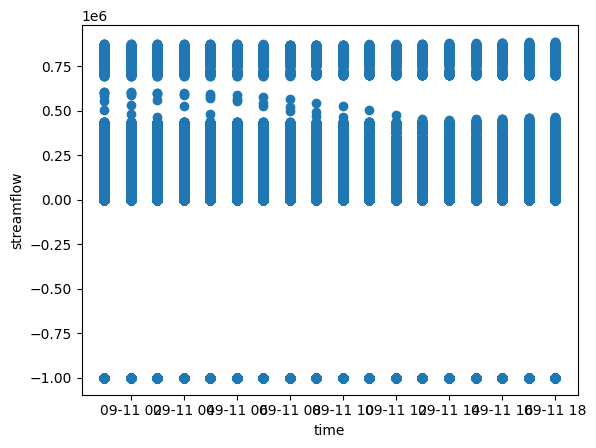

In [1]:
%%time
#pip install pyarrow, fastparquet
import dask.dataframe as dd
data = dd.read_parquet(
    "../data/parquet_all_feature_ids.gzip", engine='auto', columns=['streamflow']
)
result=data.compute()
type(result)
#result.dtypes # - streamflow data int 32
#result=result.head()
#result
#result.loc[:,:]
result.sort_index(inplace=True)
result
#result.loc["2022-09-11 01:00:00"]
#result.loc[('2022-09-11 01:00:00', 101), :]
result.loc[(slice(None), 101), :]
#result.loc[(slice(None), [101,179]), :]

r_xa = result.to_xarray()
#r_xa
r_xa.plot.scatter("time", "streamflow")